In [1]:
try:
  from google.colab import drive
  IN_COLAB=True
except:
  IN_COLAB=False

if IN_COLAB:
  print("We're running Colab")

We're running Colab


In [2]:
import tensorflow as tf

print("Running TensorFlow version ",tf.__version__)

# Parse tensorflow version
import re

version_match = re.match("([0-9]+)\.([0-9]+)", tf.__version__)
tf_major, tf_minor = int(version_match.group(1)) , int(version_match.group(2))
print("Version {v:d}, minor {m:d}".format(v=tf_major, m=tf_minor) )

Running TensorFlow version  2.7.0
Version 2, minor 7


# Derived from https://keras.io/examples/lstm_text_generation/

In [3]:
import os

MODEL_DIR = "/tmp"

if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/gdrive')

    DRIVE_DIR="/content/gdrive/My Drive/"
    MODEL_DIR=os.path.join(DRIVE_DIR, "Colab Notebooks", "NYU", "Models")
    modelDirExists = True if os.path.isdir(MODEL_DIR) else False

    if modelDirExists:
      print("Saving checkpoints to ", MODEL_DIR)

Mounted at /content/gdrive
Saving checkpoints to  /content/gdrive/My Drive/Colab Notebooks/NYU/Models


# Standard imports

In [4]:
from __future__ import print_function
import tensorflow as tf


from tensorflow.keras.callbacks import ModelCheckpoint, LambdaCallback

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.utils import get_file
import numpy as np
import random
import sys
import io
import os

from tensorflow.keras.utils import plot_model
import IPython



# Get the text file
- create maps to map between characters and their integer encodings
  - from character to integer
  - from integer to character

In [5]:
path = get_file(
    'nietzsche.txt',
    origin='https://s3.amazonaws.com/text-datasets/nietzsche.txt')
with io.open(path, encoding='utf-8') as f:
    text = f.read().lower()

eliminateBreaks = True
if eliminateBreaks:
    text = text.replace("\n", " ")
    
print('corpus length:', len(text))

chars = sorted(list(set(text)))
print('total chars:', len(chars))
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))


614400/600901 [==============================] - 1s 1us/step
corpus length: 600893
total chars: 56


# Prepare the training data: creating example sequences/targets
- example i: maxlen consecutive characters
  - text[i:i+ maxlen] training example: $x^{(i)}$
  - text[maxlen] target: $y^{(i)}$


In [6]:
# cut the text in semi-redundant sequences of maxlen characters
maxlen = 80
step = 3
sentences = []
next_chars = []
for i in range(0, len(text) - maxlen, step):
    sentences.append(text[i: i + maxlen])
    next_chars.append(text[i + maxlen])
print('nb sequences:', len(sentences))



nb sequences: 200271


# Examine the prepared input: 
- x: a prefix (of length maxlen)
- y: the following character

In [7]:
pad = len(sentences[0]) // 2
print(" i " +  " " * pad + "x" + " " * pad + "         " + "y")
print("   " +  "_" * pad + "_" + "_" * pad + "_________" + "_")


    
for i, example in enumerate( zip(sentences, next_chars)):
  if i > 9: break
  else: pass
  (sentence, next_char) = example
  print("[{i:d}]\t{sent:s}  |  {targ:s}".format(i=i, sent=sentence.replace("\n", " "), targ=next_char))

 i                                         x                                                 y
   ___________________________________________________________________________________________
[0]	preface   supposing that truth is a woman--what then? is there not ground for su  |  s
[1]	face   supposing that truth is a woman--what then? is there not ground for suspe  |  c
[2]	e   supposing that truth is a woman--what then? is there not ground for suspecti  |  n
[3]	 supposing that truth is a woman--what then? is there not ground for suspecting   |  t
[4]	pposing that truth is a woman--what then? is there not ground for suspecting tha  |  t
[5]	sing that truth is a woman--what then? is there not ground for suspecting that a  |  l
[6]	g that truth is a woman--what then? is there not ground for suspecting that all   |  p
[7]	hat truth is a woman--what then? is there not ground for suspecting that all phi  |  l
[8]	 truth is a woman--what then? is there not ground for suspecting that all phil

# One Hot Encode the characters 
- in $x^{(i)},  y^{(i)}$

In [8]:
print('Vectorization...')
x = np.zeros((len(sentences), maxlen, len(chars)), dtype=np.bool)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        x[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1




Vectorization...


# Examine the input shape
- $x^{(i)}_{(t),j}$ is found at  $x[ i, t, j ]$

  - example i
  - time step/sequence element t
  - a sequence element is a vector, index at position j
    - length of OHE (number of distinct characters)

In [9]:
print("X shape: ", x.shape)
print("\tNumber of examples: ", x.shape[0])
print("\tEach example is sequence of length ", x.shape[1])
print("\tEach element of the sequence is of length ", x.shape[2])

X shape:  (200271, 80, 56)
	Number of examples:  200271
	Each example is sequence of length  80
	Each element of the sequence is of length  56


# Utility routines

The sample routine
- takes the probability vector (one probability per potential next character)
- uses it to randomly sample the next character to produce
- `temperature`
  - our model produces a probability from a score, using the softmax, as usual for Classifiers that we have studied
  - softmax exagerates small differences in the score into larger differences in probability
  - the `temperature` controls the degree of exageration
- the routine recalculates the probability, using the desired temperature before sampling



In [10]:
def createModel():
  model = Sequential()
  model.add(LSTM(128, input_shape=(maxlen, len(chars))))
  model.add(Dense(len(chars), activation='softmax'))

  return model

def plotModel(model, modelName):
  plotFile = modelName + ".png"
  plot_model(model, plotFile, show_shapes=True)

  return plotFile
  
def sample(preds, temperature=1.0):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)


def on_epoch_end(epoch, _):
    # Function invoked at end of each epoch. Prints generated text.
    print()
    print('----- Generating text after Epoch: %d' % epoch)

    start_index = random.randint(0, len(text) - maxlen - 1)
    diversities = [0.2, 0.5, 1.0, 1.2]
    for diversity in diversities[:2]:
        # print('----- diversity:', diversity)

        generated = ''
        sentence = text[start_index: start_index + maxlen]
        generated += sentence
        print('\n----- Generating with seed (diversity={d:3.2f}): "{sent:s}"\n\t'.format(d=diversity, sent=sentence) )
        sys.stdout.write(generated)

        # Generate some text, based on the currently constructed sentence
        len_to_generate = 400
        for i in range(len_to_generate):
            # Encode the characters of sentence as OHE vectors over the set of characters chars
            x_pred = np.zeros((1, maxlen, len(chars)))
            for t, char in enumerate(sentence):
                # One Hot Encode word t of sentence
                x_pred[0, t, char_indices[char]] = 1.

            # Predict next character
            preds = model.predict(x_pred, verbose=0)[0]

            # prediction preds is a probability vector; sample from it to get next character next_char
            next_index = sample(preds, diversity)
            next_char = indices_char[next_index]

            # Append next_char to sentence
            sentence = sentence[1:] + next_char

            sys.stdout.write(next_char)
            sys.stdout.flush()
        print()



Build model...


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


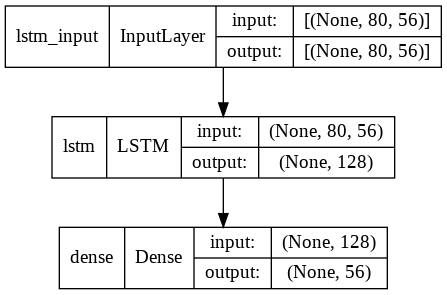

In [11]:
# build the model: a single LSTM
print('Build model...')
model = createModel()

optimizer = RMSprop(lr=0.01)
model.compile(loss='categorical_crossentropy') #, optimizer=optimizer)

plotFile = plotModel(model, "first_model")
IPython.display.Image(plotFile) 



# Resume training from existing weights ?
- Training takes a long time.  We can resume training from a previously stored checkpoint
- The name of the checkpoint file depends on
  - The maxlen variable (max sequence length)
  - The loss from the saved session
- To resume from a checkpoint
  - set saveLoss to be equal to the loss of the saved checkpoint

If the checkpoint file doesn't exist, training will start from scratch

In [20]:
savedLoss = 0.9567
modelFile = os.path.join(MODEL_DIR, "lstm_text_gen_{len:d}_-loss_{loss:.4f}.h5".format(len=maxlen, loss=savedLoss)) # None

if modelFile is not None and os.path.exists(modelFile):
  print("Initializing with weights from ", modelFile)
  model.load_weights(modelFile)

Initializing with weights from  /content/gdrive/My Drive/Colab Notebooks/NYU/Models/lstm_text_gen_80_-loss_0.9567.h5


In [18]:
print_callback = LambdaCallback(on_epoch_end=on_epoch_end)

ckpt_filepath=os.path.join(MODEL_DIR, "lstm_text_gen_{len:d}_-loss_".format(len=maxlen) + "{loss:.4f}.h5")
checkpoint_callback = ModelCheckpoint(ckpt_filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')



# Train

In [19]:
callbacks = [print_callback]

modelDirExists = True if os.path.isdir(MODEL_DIR) else False
if modelDirExists:
  callbacks.append(checkpoint_callback)

model.fit(x, y,
          batch_size=128,
          epochs=60,
          callbacks=callbacks)

Epoch 1/60
1564/1565 [============================>.] - ETA: 0s - loss: 0.9791
----- Generating text after Epoch: 0

----- Generating with seed (diversity=0.20): "nciple of the "smallest possible effort," and the greatest possible blunder. "wh"
	
nciple of the "smallest possible effort," and the greatest possible blunder. "what is the causes and also a long to his faith in which the fissed to the sense of the same pain as to something and the species which is the same pain as almost enough not the controrary to the sense of the scholar is in the sake of the same power, and the elight of the conscience with itlewa"d to be so that there is no longer in the same time of metaphysical entyrets in the severent entancity, th

----- Generating with seed (diversity=0.50): "nciple of the "smallest possible effort," and the greatest possible blunder. "wh"
	
nciple of the "smallest possible effort," and the greatest possible blunder. "what is the brain of completeness, but is most to such as the s